In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pickle

from joblib import Parallel, delayed
np.random.seed(5)

### Implementation of M/M/n queue system
In order to implement the M/M/n queue, we begin with creating the `Request` class. A request is initialized with a provided id, an arrival time and a service time. When the request is processed, the wait time is logged.

In [2]:
class Request:
    """Represents a single request in a M/M/n queue"""
    def __init__(self, request_id, arrival_time, service_time):
        self.request_id = request_id
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.wait_time = None

    def log_wait(self, wait_time):
        """Log waiting time"""
        self.wait_time = wait_time

# Generate service times using np.random.choice
def generate_service_time(probabilities, scales):
    choice = np.random.choice(len(probabilities), p=probabilities)
    return np.random.exponential(scale=1/scales[choice])

In [3]:
# p = [0.75, 0.25]
# scales [ 1, 1/5]

The `MMNqueue` class simulates an M/M/n queueing system with configurable scheduling policies (`FIFO` or `SJF`) and adjustable service parameters.


In [4]:
class MMNqueue:
    """Simulates an M/M/n queue."""
    def __init__(self, simpy_env, num_servers, service_probabilities, service_scales, num_requests, arrival_rate, scheduler_type="FIFO"):
        self.env = simpy_env
        self.num_servers = num_servers
        self.service_probabilities = service_probabilities
        self.service_scales = service_scales
        self.arrival_rate = arrival_rate

        match scheduler_type:
            case "FIFO" : self.pool = simpy.Resource(self.env, capacity=num_servers)
            case "SJF"  : self.pool = simpy.PriorityResource(self.env, capacity=num_servers)

        # Request information
        self.completed_requests = 0
        self.requests = []
        self.num_requests = num_requests

    def generate_request(self, request_id):
        """Generate a new request."""
        return Request(request_id, self.env.now, generate_service_time(self.service_probabilities, self.service_scales))

    def handle_request(self, request):
        """Handle requests using the selected resource (FIFO or SJF)."""
        if isinstance(self.pool, simpy.PriorityResource):
            # SJF: Use priority based on service time
            with self.pool.request(priority=request.service_time) as req:
                yield req
                request.log_wait(self.env.now - request.arrival_time)
                yield self.env.timeout(request.service_time)

            self.requests.append(request)  # Store the processed request
            self.completed_requests += 1
        else:
            # FIFO: No priority, just use FIFO
            with self.pool.request() as req:
                yield req
                request.log_wait(self.env.now - request.arrival_time)
                yield self.env.timeout(request.service_time)

            self.requests.append(request)  # Store the processed request
            self.completed_requests += 1

    def arrival_process(self):
        """Simulate the arrival process of requests."""
        request_id = 0
        while self.completed_requests < self.num_requests:
            yield self.env.timeout(np.random.exponential(1 / self.arrival_rate))  # Inter-arrival time
            request = self.generate_request(request_id)
            request_id += 1
            # Add request to the appropriate resource queue (based on FIFO/SJF)
            self.env.process(self.handle_request(request))  # Process the request


### Implementation of M/D/n queue system
The `MDNqueue` class extends the `MMNqueue` class to simulate an M/M/n queueing system with an additional parameter $D$. Now, requests have a constant service time, defined as $1/D$. 

In [5]:
class MDNqueue(MMNqueue):
    def __init__(self, simpy_env, num_servers, num_requests, D, arrival_rate):
        self.env = simpy_env
        self.num_servers = num_servers
        self.D = D
        self.arrival_rate = arrival_rate
        self.pool = simpy.Resource(self.env, capacity=num_servers)
        # Request information
        self.completed_requests = 0
        self.requests = []
        self.num_requests = num_requests

    def generate_request(self, request_id):
        """Generate a new request."""
        return Request(request_id, self.env.now, 1/self.D)

### Simulation Wrapper
The `run_simulation` function simulates queueing behavior using the SimPy framework. It supports different types of queueing systems, such as **MMN** and **MDN**, and scheduling policies, such as **FIFO** and **SJF**, and returns metrics like wait times and service times.

In [6]:
def run_simulation(num_requests, num_servers, arrival_rate, D=None, service_probabilities=None, service_scales=None, scheduler_type=None, queue_type="MMN"):
    env = simpy.Environment()

    match queue_type:
        case "MMN" : queue_sim = MMNqueue(
            simpy_env=env,
            num_servers=num_servers,
            service_probabilities=service_probabilities,
            service_scales=service_scales,
            num_requests=num_requests,
            arrival_rate=arrival_rate,
            scheduler_type=scheduler_type,
        )
        case "MDN" : queue_sim = MDNqueue(
            simpy_env=env,
            num_servers=num_servers,
            D=D,
            num_requests=num_requests,
            arrival_rate=arrival_rate
        )

    env.process(queue_sim.arrival_process())

    env.run()

    wait_times = [req.wait_time for req in queue_sim.requests if req.wait_time is not None]
    service_times = [req.service_time for req in queue_sim.requests]

    return {
        "wait_times": wait_times,
        "service_times": service_times,
        "num_completed_requests": len(queue_sim.requests) if queue_type == "MDN" else len(queue_sim.requests),
        "num_total_requests": num_requests,
    }

### Theoretical Waiting Time
`calculate_theoretical_waiting_time` computes the exact average waiting time according to queueing theory. **MDN** has no exact, closed-form solution, and is therefore omitted.

In [7]:
def calculate_theoretical_waiting_time(lamda=None, mu=None, n=1, queue_type="MMN"):
    """
    Calculate the theoretical average waiting time in a queueing system.

    Parameters:
        lamda (float): Arrival rate.
        mu (float): Service rate.
        n (int): Number of servers (default: 1).
        queue_type (str): Type of queue ("MMN" or "MDN").

    Returns:
        float: Theoretical waiting time.
    """
    if queue_type == "MMN":
        return _calculate_mmn_waiting_time(lamda, mu, n)
    elif queue_type == "MDN":
        return _calculate_mdn_waiting_time(lamda, mu, n)
    else:
        raise ValueError(f"Unsupported queue type: {queue_type}")


def _calculate_mmn_waiting_time(lamda, mu, n):
    """
    Calculate theoretical waiting time for M/M/n queues.
    """
    if n == 1:
        # Single-server M/M/1 formula
        return lamda / (mu**2 - lamda * mu)
    else:
        # Multi-server M/M/n formula
        p_sum = sum((1 / sp.special.factorial(j, exact=True)) * (lamda / mu)**j for j in range(n))
        p_sum += (1 / sp.special.factorial(n, exact=True)) * (mu * n / (mu * n - lamda)) * (lamda / mu)**n
        P_0 = 1 / p_sum

        Lq = (P_0 * (1 / sp.special.factorial(n - 1, exact=True)) *
              (lamda * mu / (n * mu - lamda)**2) * (lamda / mu)**n)
        W = Lq / lamda
        return W


def _calculate_mdn_waiting_time(lamda, mu, n):
    """
    Calculate theoretical waiting time for M/D/n queues.
    """
    if n == 1:
        # Single-server M/D/1 formula
        return (lamda / (2 * mu * (mu - lamda))) + (1 / mu)
    else:
        raise NotImplementedError("M/D/n for n > 1 is not implemented.")


### Trial Set-up
To check if everything works as expected, we run a trial for all scheduling policies and queue types.
- **num_requests**: `20000`  
  Total number of requests to simulate.

- **num_servers**: `1` or `2`  
  Number of servers in the system.

- **arrival_rate**: `1/5`  
  The inter-arrival time rate for incoming requests.

- **service_probabilities**: `[1]`  
  Probabilities assigned to different service times (example values).

- **service_scales**: `[1/4.5]`  
  Service rates corresponding to the probabilities (example values).

- **D**: `1/4.5`  
  Deterministic service time (used for MDN queues).

- **burn_in_percentage**: `0.10`  
  Proportion of the simulation to discard as a "burn-in" period.

- **burn_in_count**: `int(num_requests * burn_in_percentage)`  
  Number of requests to ignore during the burn-in phase. In this case, `2000`.


In [8]:
# Parameters
num_requests = 20000
num_servers = [1, 2, 4]
arrival_rate = 1/5  # Inter-arrival time
service_probabilities = [1]  # Example probabilities for different service times
service_scales = [1/4.5]  # Example service rates
D = 1/4.5
burn_in_percentage = 0.10
burn_in_count = int(num_requests * burn_in_percentage)

In [9]:
print(f"{'-' * 16} M/M/{num_servers[0]} results {'-' * 16}")
# Run FIFO simulation (M/M/N)
fifo_result = run_simulation(num_requests=num_requests, num_servers=num_servers[0], arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type="FIFO", queue_type="MMN")
print(f'FIFO Results (M/M/1): {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')
print(f'Theoretical Expectation (M/M/1): {calculate_theoretical_waiting_time(lamda = arrival_rate, mu =service_scales[0], n = num_servers[0]):.4f}')

# Run SJF simulation (M/M/1)
sjf_result = run_simulation(num_requests=num_requests, num_servers=num_servers[0], arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type="SJF", queue_type="MMN")
print(f'SJF Results (M/M/1): {np.mean(sjf_result["wait_times"][burn_in_count:]):.4f}')

print(f"{'-' * 16} M/D/{num_servers[0]} results {'-' * 16}")
# Run FIFO simulation (M/D/1)
fifo_result = run_simulation(num_requests=num_requests, num_servers=num_servers[0], arrival_rate=arrival_rate, D=D, scheduler_type="FIFO", queue_type="MDN")
print(f'FIFO Results (M/D/1): {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')
print(f'Theoretical Expectation (M/D/1): {calculate_theoretical_waiting_time(lamda = arrival_rate, mu =D, n=num_servers[0], queue_type="MDN"):.4f}')

print(f"{'-' * 16} M/M/{num_servers[1]} results {'-' * 16}")
# Run FIFO simulation (M/M/N)
fifo_result = run_simulation(num_requests=num_requests, num_servers=num_servers[1], arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type="FIFO", queue_type="MMN")
print(f'FIFO Results (M/M/2): {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')
print(f'Theoretical Expectation (M/M/2): {calculate_theoretical_waiting_time(lamda = arrival_rate, mu =service_scales[0], n = num_servers[1]):.4f}')

# Run SJF simulation (M/M/N)
sjf_result = run_simulation(num_requests=num_requests, num_servers=num_servers[1], arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type="SJF", queue_type="MMN")
print(f'SJF Results (M/M/2): {np.mean(sjf_result["wait_times"][burn_in_count:]):.4f}')

print(f"{'-' * 16} M/M/{num_servers[1]} results {'-' * 16}")
# Run FIFO simulation (M/D/N)
fifo_result = run_simulation(num_requests=num_requests, num_servers=num_servers[1], arrival_rate=arrival_rate, D=D, scheduler_type="FIFO", queue_type="MDN")
print(f'FIFO Results (M/D/2): {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')

---------------- M/M/1 results ----------------
FIFO Results (M/M/1): 38.9427
Theoretical Expectation (M/M/1): 40.5000
SJF Results (M/M/1): 14.3428
---------------- M/D/1 results ----------------
FIFO Results (M/D/1): 21.1304
Theoretical Expectation (M/D/1): 24.7500
---------------- M/M/2 results ----------------
FIFO Results (M/M/2): 1.1303
Theoretical Expectation (M/M/2): 1.1426
SJF Results (M/M/2): 0.9040
---------------- M/M/2 results ----------------
FIFO Results (M/D/2): 0.5739


### Mutlithreading Simulations

We use JobLibs to run the simulations in parallel in order to save time / add more simulation. The parameter `n_jobs` is set to `-1`, meaning that all available cores on the user's computer are used. If you want to use, for instance, 4 out of 8 cores, set `n_jobs = 4`.

In [10]:
def simulation_wrapper_MMN(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type, queue_type):
    """Wrapper for MMN queue."""
    return run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type=scheduler_type, queue_type=queue_type)

def simulation_wrapper_MDN(num_requests, num_servers, arrival_rate, D, scheduler_type, queue_type):
    """Wrapper for MDN queue."""
    return run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, D=D, scheduler_type=scheduler_type, queue_type=queue_type)

def simulate_parallel(n_runs, num_requests, num_servers, arrival_rate, service_probabilities, service_scales, D, scheduler_type="FIFO", queue_type="MMN"):
    """Uses the functions above to run n_runs simulations in parallel.

    Args:
        n_runs (int): Number of simulations
        num_requests (int): total number of queueing people
        num_servers (int): number of servers, n
        arrival_rate (float): arrival rate, lambda
        service_probabilities (float): probability of being helped
        service_scales (float): service rate, mu
        D (float): deterministic service rate, mu
        scheduler_type (str, optional): type of scheduling, FIFO or SJF. Defaults to "FIFO".
        queue_type (str, optional): type of queueing (MMN/MDN/MHN). Defaults to "MMN".

    Returns:
        list: list of all n_runs simulations.
    """
    match queue_type:
        case "MMN" : return Parallel(n_jobs=2)(delayed(simulation_wrapper_MMN)(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type=scheduler_type, queue_type=queue_type) for _ in range(n_runs))
        case "MDN" : return Parallel(n_jobs=2)(delayed(simulation_wrapper_MDN)(num_requests, num_servers, arrival_rate, D, scheduler_type=scheduler_type, queue_type=queue_type) for _ in range(n_runs))

The cell below calculates the statistics for the simlated queues. Such as the mean of the samples, the $\chi^2$, and the p-value.

In [11]:
def calc_statistics(means, stds, arrival_rate, service_rate, num_servers, num_simulations, queue_type):
    """Calculates general statistics for simulations, including (theoretical) mean, 95% confindence interval, (critical) chi2.

    Args:
        means (array): calculated mean waiting times
        stds (array): calculated std waiting times
        arrival_rate (float): arrival rate, lambda
        service_rate (float): service rate, mu
        num_servers (int): number of servers, n
        num_simulations (int): number of simulations
        queue_type (str): type of queue, i.e., M/M/N, M/D/N, or M/H/N

    Returns:
        list: list of statistics used for plotting.
    """
    E_theo = calculate_theoretical_waiting_time(arrival_rate, service_rate, num_servers, queue_type)
    exp_mean = np.mean(means)
    conf95 = 1.96*stds/np.sqrt(num_simulations)
    chi_squared = np.sum((means-E_theo)**2 / conf95**2)
    critical_value = sp.stats.chi2.ppf(0.95, num_simulations - 1)
    p_value = 1 - sp.stats.chi2.cdf(chi_squared, num_simulations - 1)

    return [E_theo, exp_mean, conf95, chi_squared, critical_value, p_value]

### Simulations for Results
Below is a detailed explanation of the parameters used in the simulation:

1. **Number of Requests** (`num_requests`):  
   Total number of requests to simulate in the queueing system.  
   **Value**: `10,000`

2. **Number of Servers** (`num_servers`):  
   A list specifying the number of servers to evaluate in the simulation.  
   **Value**: `[1, 2, 4]`

3. **Arrival Rate** (`arrival_rate`):  
   The average rate at which requests arrive in the system, defined as the reciprocal of the inter-arrival time.  
   **Value**: `1/5` (1 request every 5 units of time)

4. **Service Probabilities** (`service_probabilities`):  
   Probabilities associated with different service times, if multiple service times are considered.  
   **Value**: `[1]` (All requests have the same service rate)

5. **Service Scales** (`service_scales`):  
   The average rate of service for requests, defined as the reciprocal of the service time.  
   **Value**: `[1/4.5]` (Average service time of 4.5 units)

6. **Deterministic Service Rate** (`D`):  
   The deterministic equivalent of the average service rate.  
   **Value**: `4.5`

7. **Burn-in Percentage** (`burn_in_percentage`):  
   The proportion of requests to exclude from the beginning of the simulation to avoid transient effects.  
   **Value**: `0.05` (5%)

8. **Burn-in Count** (`burn_in_count`):  
   The number of requests to exclude as part of the burn-in period, calculated as a percentage of `num_requests`.  
   **Value**: `500` (5% of 10,000)

9. **Number of Simulations** (`num_simulations`):  
   The total number of simulation runs to perform for statistical analysis.  
   **Value**: `100`

10. **X-Axis Range for Plots** (`x_axis_plots`):  
    The range of simulation numbers used for plotting results.  
    **Value**: `1 to 100`

In [12]:
num_requests = 10000
num_servers = [1, 2, 4]
arrival_rate = 1/5  # Inter-arrival time
service_probabilities = [1]  # Example probabilities for different service times
service_scales = [1/4.5]  # Example service rates
D = 4.5
burn_in_percentage = 0.05
burn_in_count = int(num_requests * burn_in_percentage)
num_simulations = 100
x_axis_plots = range(1, num_simulations+1)

#### Simulating FIFO and SJF scheduling for comparison

We simulate the queues for $n = 1, 2, 4$ servers and extract the waiting times of the simulations. We will compare the results to the theoretical value for the waiting time and the $\chi^2$ is calculated using `calculate_statistics` to determine whether our result is statistically significant. In the case of SJF, there is no theoretical value that we can use for reference, we can only compare the mean of the measurements to the mean of FIFO.

In [13]:
sim_means_fifo = np.zeros((len(num_servers), num_simulations))
sim_stds_fifo = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    fifo_result = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, D, scheduler_type="FIFO", queue_type="MMN")

    for i in range(num_simulations):
        sim_means_fifo[j, i] = np.mean(fifo_result[i]["wait_times"][burn_in_count:])
        sim_stds_fifo[j ,i] = np.std(fifo_result[i]["wait_times"][burn_in_count:])

In [14]:
fifo_single_server_stats = calc_statistics(sim_means_fifo[0], sim_stds_fifo[0], num_servers[0]*arrival_rate, service_scales[0], 1, num_simulations, "MMN")
fifo_two_server_stats = calc_statistics(sim_means_fifo[1], sim_stds_fifo[1], num_servers[1]*arrival_rate, service_scales[0], 2, num_simulations, "MMN")
fifo_four_server_stats = calc_statistics(sim_means_fifo[2], sim_stds_fifo[2], num_servers[2]*arrival_rate, service_scales[0], 4, num_simulations, "MMN")

In [15]:
sim_means_sjf = np.zeros((len(num_servers), num_simulations))
sim_stds_sjf = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    sjf_result = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, D, scheduler_type="SJF", queue_type="MMN")

    for i in range(num_simulations):
        sim_means_sjf[j, i] = np.mean(sjf_result[i]["wait_times"][burn_in_count:])
        sim_stds_sjf[j ,i] = np.std(sjf_result[i]["wait_times"][burn_in_count:])

In [16]:
sjf_single_server_mean = np.mean(sim_means_sjf[0])
sjf_single_conf95 = 1.96 * sim_stds_sjf[0] / np.sqrt(num_simulations)
sjf_two_server_mean = np.mean(sim_means_sjf[1])
sjf_two_conf95 = 1.96 * sim_stds_sjf[1] / np.sqrt(num_simulations)
sjf_four_server_mean = np.mean(sim_means_sjf[2])
sjf_four_conf95 = 1.96 * sim_stds_sjf[2] / np.sqrt(num_simulations)

We save files so that we do not have to re-run our simulations if we wish to adjust any plots

In [17]:
with open('fifo_single_server_stats.pkl', 'wb') as f:
    pickle.dump(fifo_single_server_stats, f)

with open('fifo_two_server_stats.pkl', 'wb') as f:
    pickle.dump(fifo_two_server_stats, f)

with open('fifo_four_server_stats.pkl', 'wb') as f:
    pickle.dump(fifo_four_server_stats, f)

In [18]:
with open('fifo_single_server_stats.pkl', 'rb') as f:
    fifo_single_server_stats = pickle.load(f)

with open('fifo_two_server_stats.pkl', 'rb') as f:
    fifo_two_server_stats = pickle.load(f)

with open('fifo_four_server_stats.pkl', 'rb') as f:
    fifo_four_server_stats = pickle.load(f)

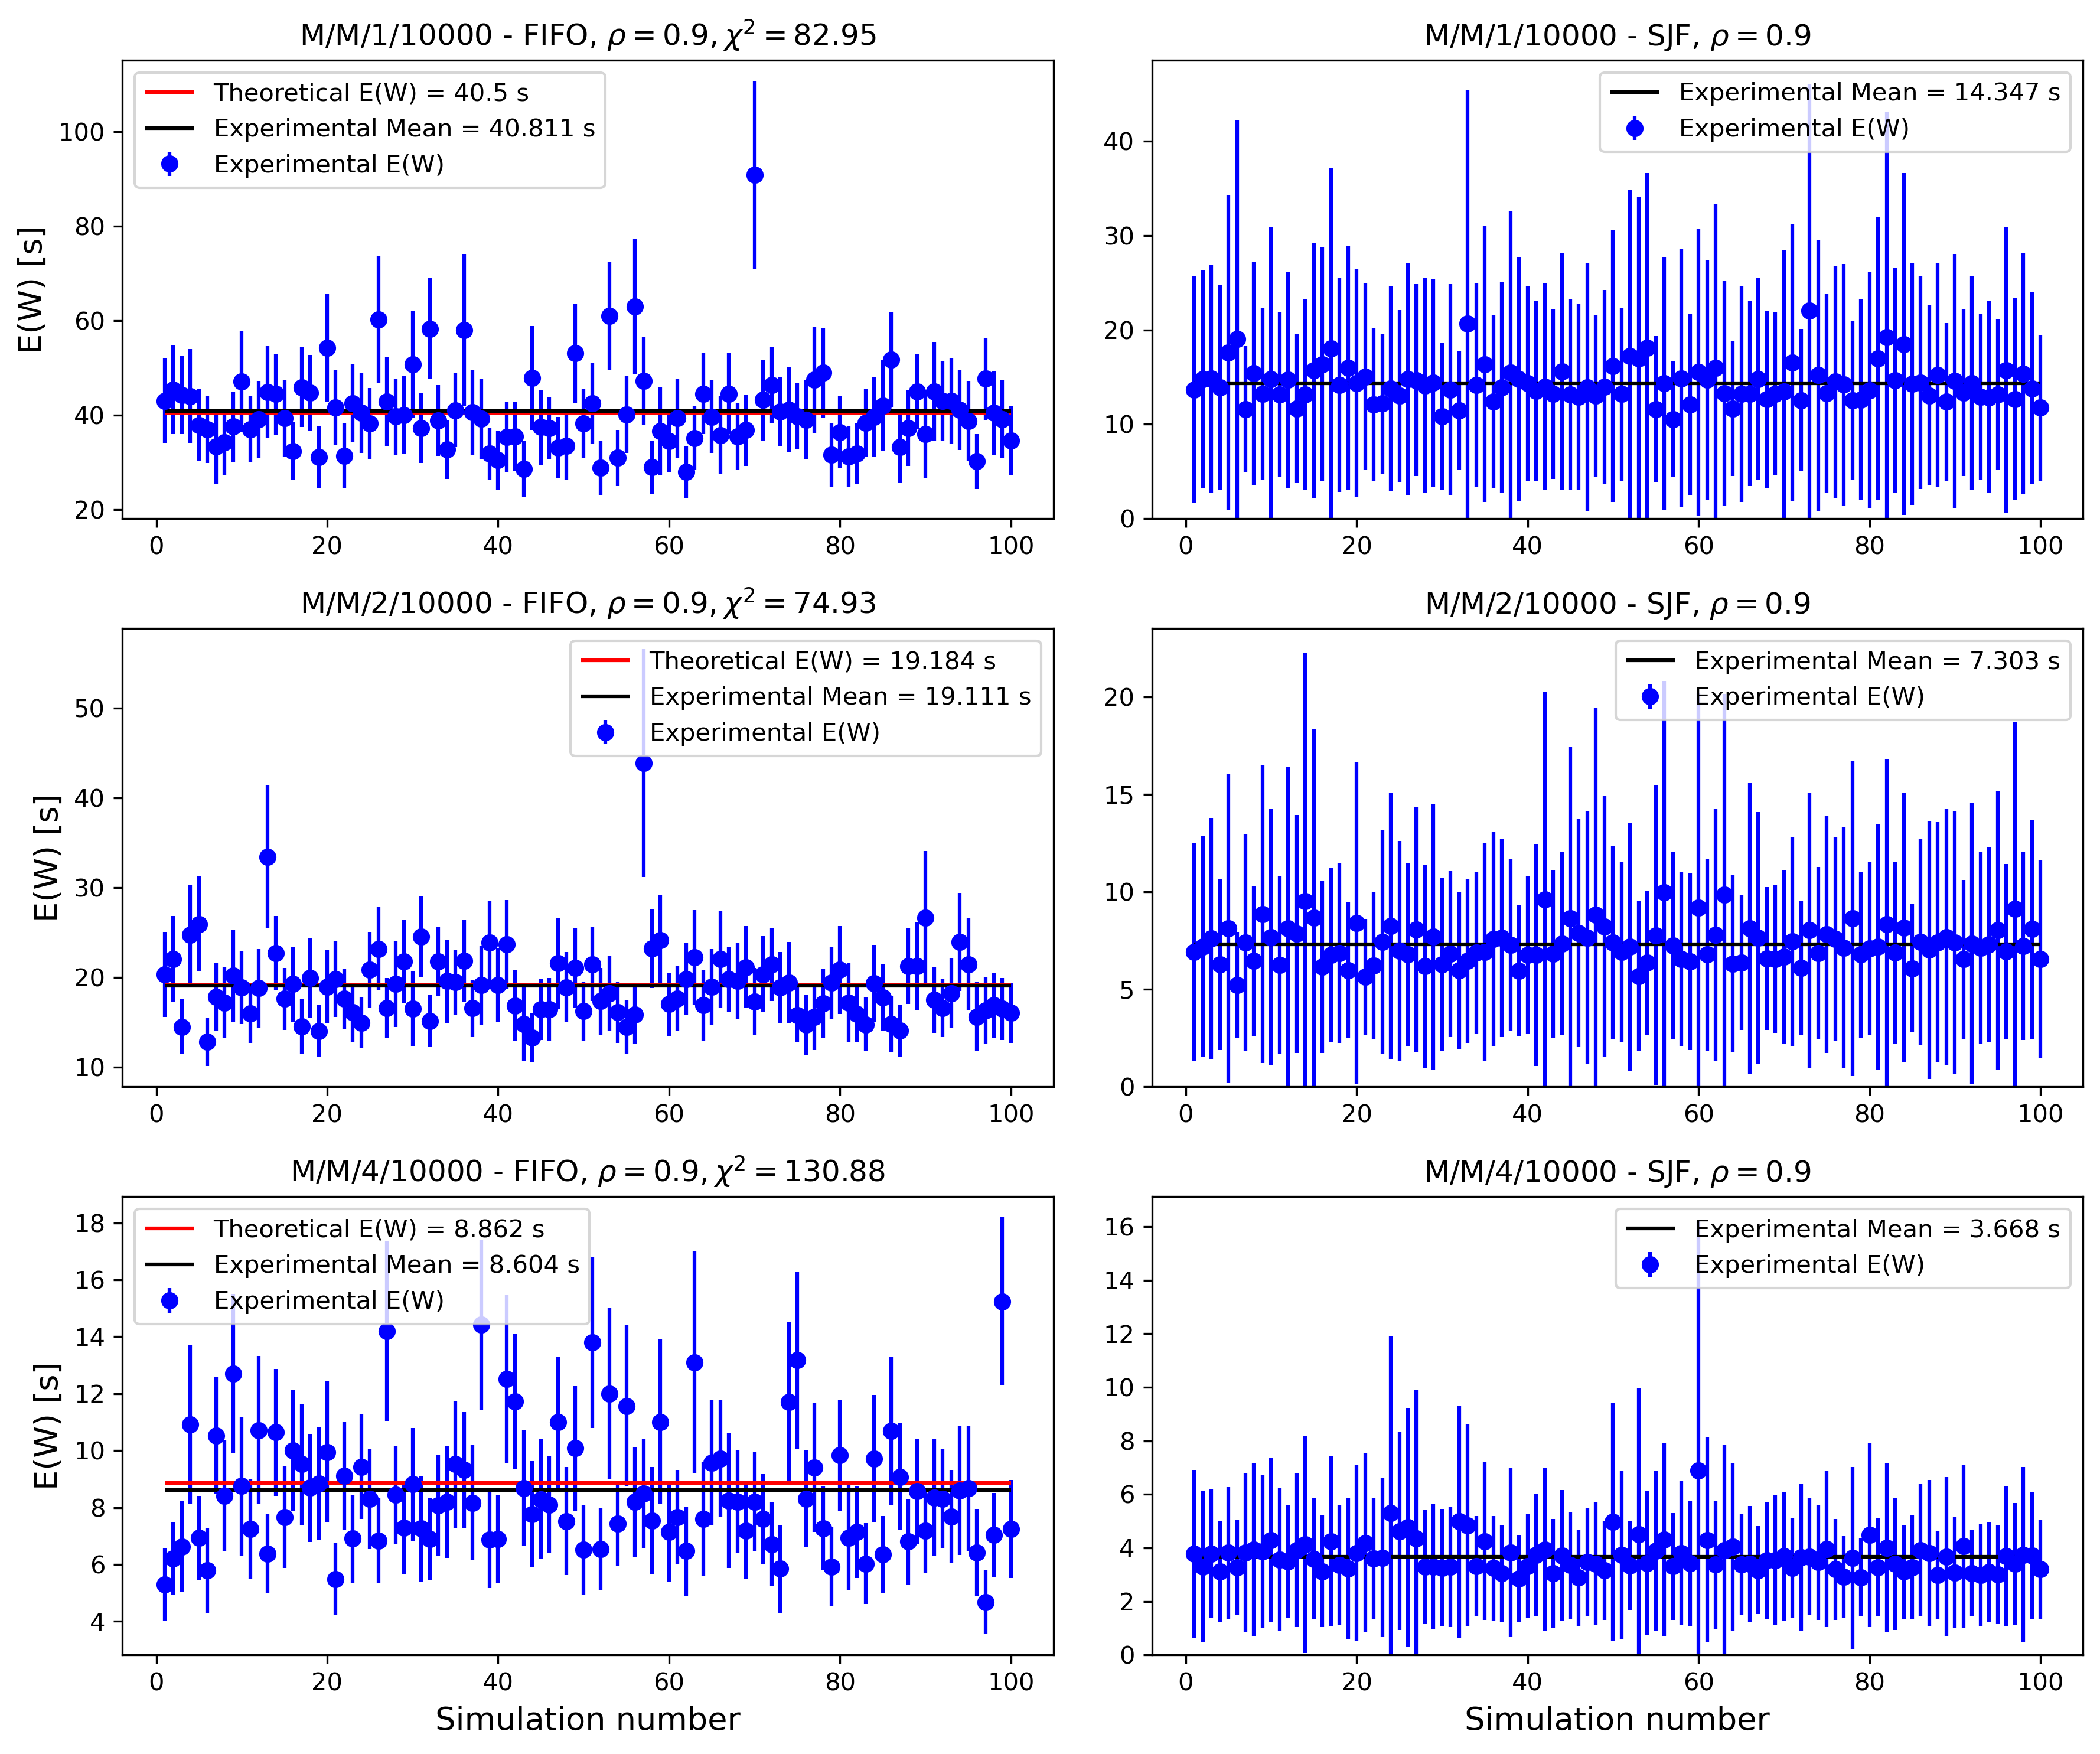

In [19]:
plt.figure(figsize=(12, 10), dpi=300)

plt.subplot(3,2,1)
plt.title(fr'M/M/{num_servers[0]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}, \chi^2 = {round(fifo_single_server_stats[3], 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo[0], yerr=fifo_single_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_single_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_single_server_stats[0], 3)} s')
plt.hlines(fifo_single_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_single_server_stats[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,3)
plt.title(fr'M/M/{num_servers[1]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}, \chi^2 = {round(fifo_two_server_stats[3], 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo[1], yerr=fifo_two_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_two_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_two_server_stats[0], 3)} s')
plt.hlines(fifo_two_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_two_server_stats[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,5)
plt.title(fr'M/M/{num_servers[2]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}, \chi^2 = {round(fifo_four_server_stats[3], 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo[2], yerr=fifo_four_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_four_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_four_server_stats[0], 3)} s')
plt.hlines(fifo_four_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_four_server_stats[1], 3)} s')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,2)
plt.title(fr'M/M/{num_servers[0]}/{num_requests} - SJF, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_sjf[0], yerr=sjf_single_conf95, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_single_server_mean, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_single_server_mean, 3)} s')
plt.ylim(0,None)
plt.legend()

plt.subplot(3,2,4)
plt.title(fr'M/M/{num_servers[1]}/{num_requests} - SJF, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_sjf[1], yerr=sjf_two_conf95, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_two_server_mean, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_two_server_mean, 3)} s')
plt.ylim(0,None)
plt.legend()

plt.subplot(3,2,6)
plt.title(fr'M/M/{num_servers[2]}/{num_requests} - SJF, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_sjf[2], yerr=sjf_four_conf95, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_four_server_mean, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_four_server_mean, 3)} s')
plt.ylim(0,None)
plt.legend()
plt.xlabel('Simulation number', fontsize=13)

plt.tight_layout()
plt.show()

#### Impact of number of simulations on statistical significance

We increase the parameter $\rho$ to nearly 1 (by increasing the $\lambda$ and keeping $\mu$ constant) to observe how the $\chi^2$ changes for a different number of simulations. If $\chi^2$ increases above its critical value, the result is no longer significant. This is done for an $M/M/1$ queue.

In [20]:
def chi2_vs_rho(num_sim, num_requests, n_servers, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN"):
    """Calculates Chi^2 for different values of rho (service load) and number of simulations.

    Args:
        num_sim (int): number of simulations
        num_requests (int): number of queueing people
        n_servers (int): number of servers
        arr_rate_list (list): list of different arrival rates for different values of rho
        service_probabilities (float): probability of being helped
        service_scales (float): service rate, mu
        scheduler_type (str, optional): type of scheduling, FIFO or SJF. Defaults to "FIFO".
        queue_type (str, optional): type of queueing, (MMN, MDN, MHN). Defaults to "MMN".

    Returns:
        lists: lists for chi2's and the corresponding critical values.
    """

    chi_test_means = np.zeros((len(arr_rate_list),num_sim))
    chi_test_stds = np.zeros((len(arr_rate_list),num_sim))

    for i, rate in enumerate(arr_rate_list):
        chi_test = simulate_parallel(num_sim, num_requests, n_servers, rate, service_probabilities, service_scales, D, scheduler_type=scheduler_type, queue_type=queue_type)
        for j in range(num_sim):
            chi_test_means[i, j] = np.mean(chi_test[j]["wait_times"][burn_in_count:])
            chi_test_stds[i,j] = np.std(chi_test[j]["wait_times"][burn_in_count:])

    chis = []
    for i in range(len(arr_rate_list)):
        _, _, _, chisq, crit_val, _ = calc_statistics(chi_test_means[i], chi_test_stds[i], arr_rate_list[i], service_scales[0], 1, num_sim, "MMN")
        chis.append(chisq)

    return chis, crit_val

In [21]:
arr_rate_list = [1/5, 1/4.9, 1/4.8, 1/4.7, 1/4.6, 1/4.55]
rho = np.array(arr_rate_list) / service_scales[0]

chis_10, chi_10_crit = chi2_vs_rho(10, 5000, 1, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN")
chis_50, chi_50_crit = chi2_vs_rho(50, 5000, 1, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN")
chis_100, chi_100_crit = chi2_vs_rho(100, 5000, 1, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN")

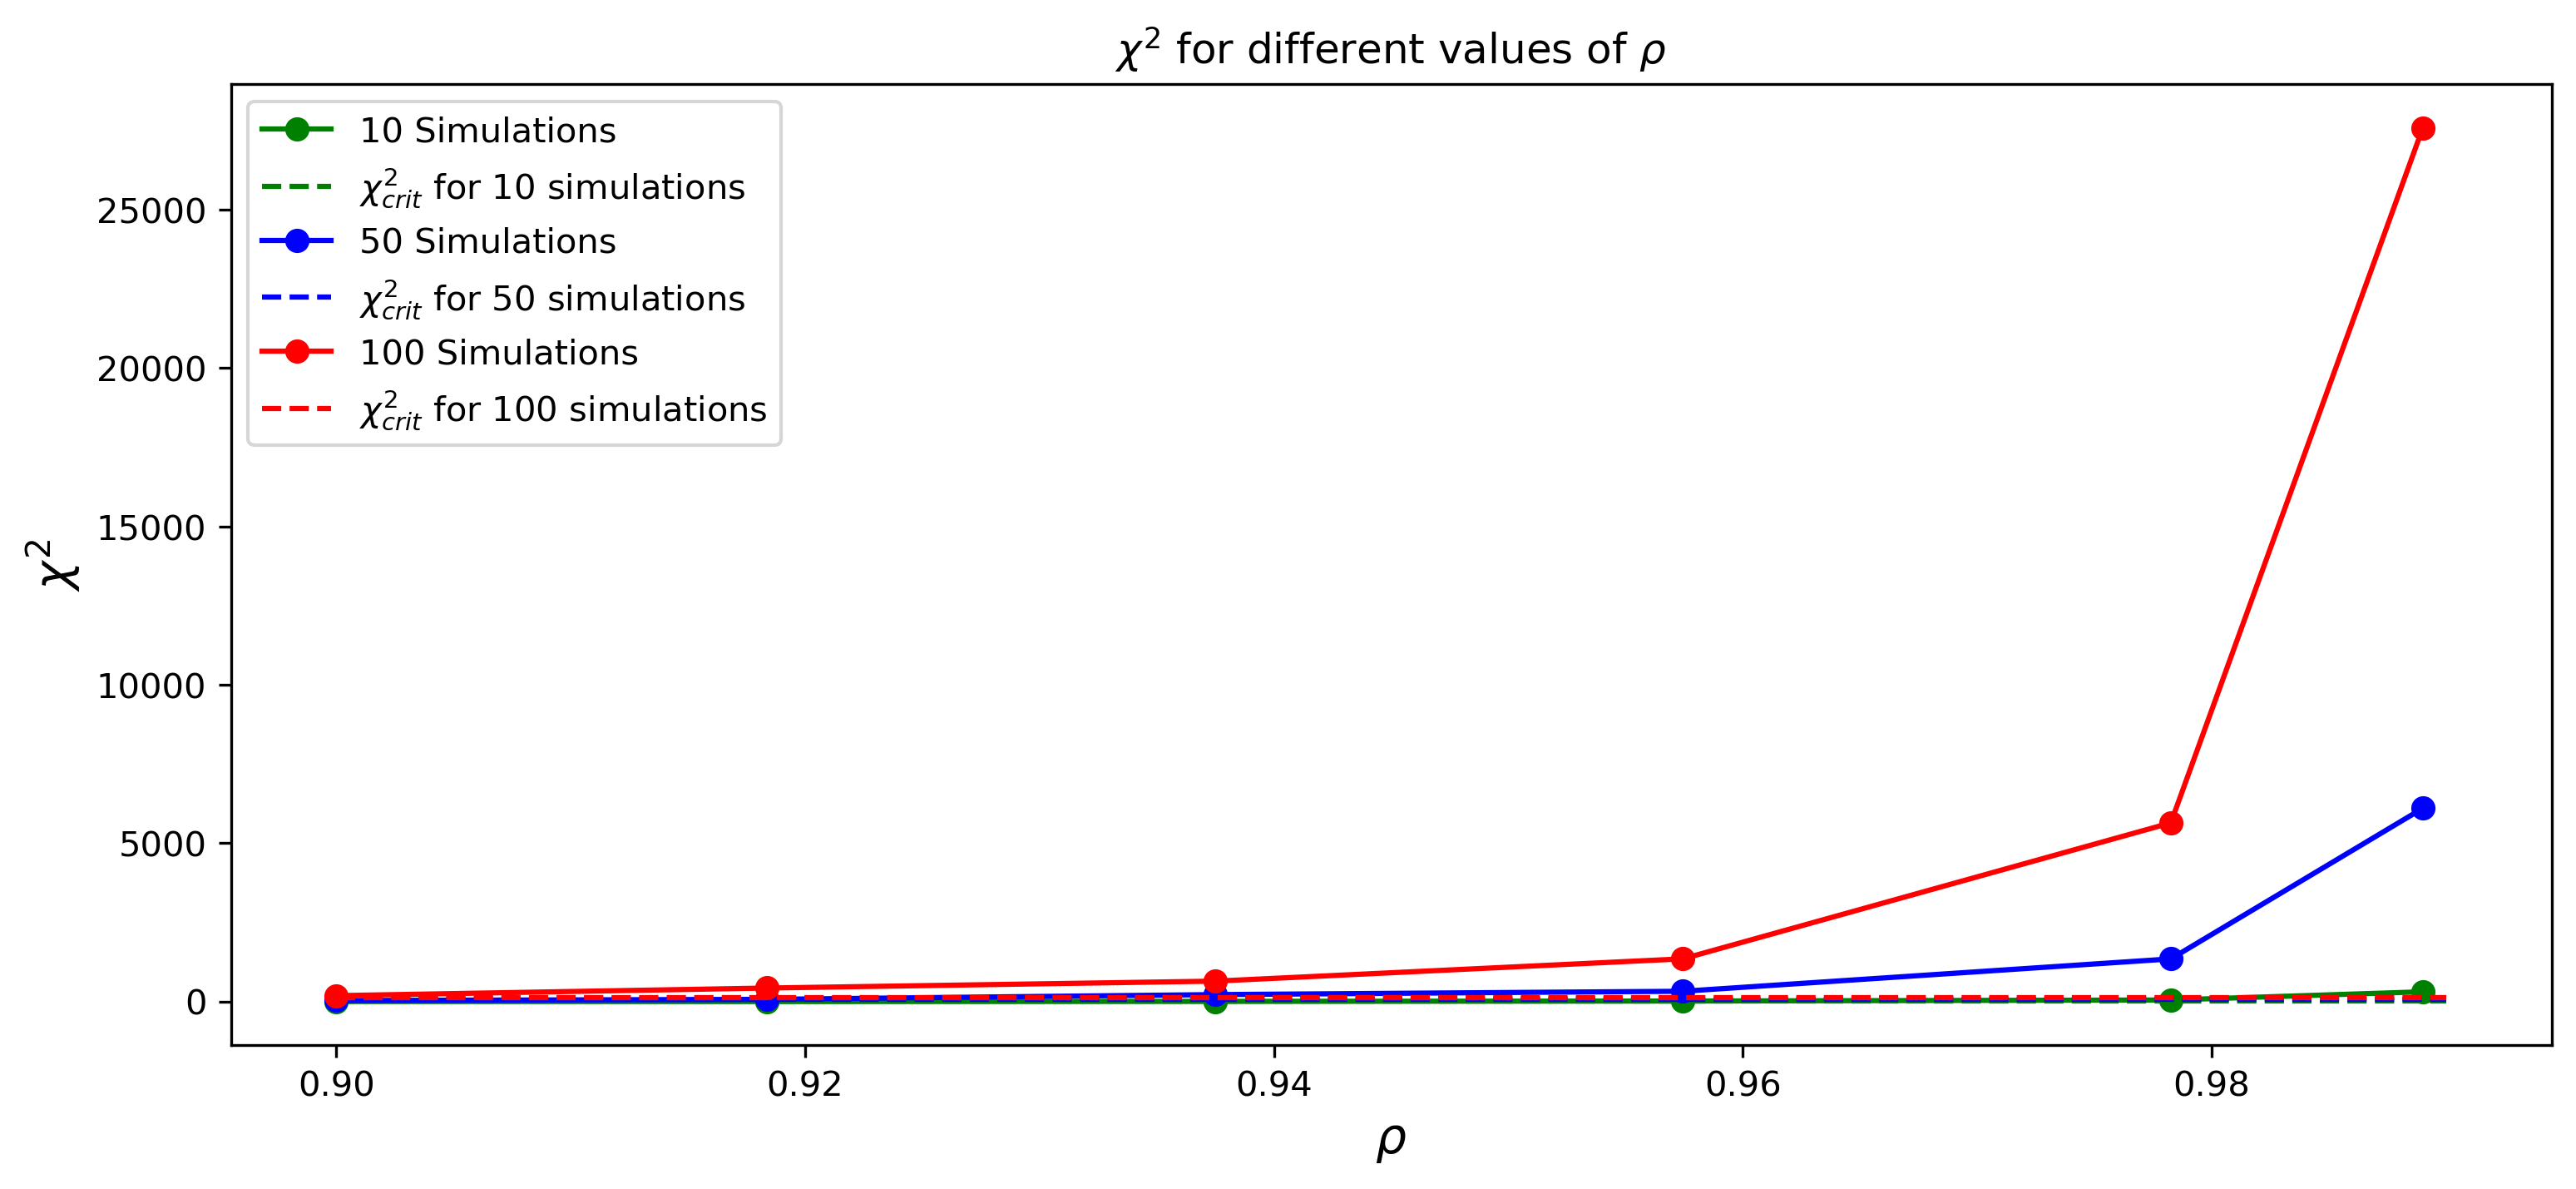

In [22]:
plt.figure(figsize=(12, 5), dpi=300)
plt.title(r'$\chi^2$ for different values of $\rho$')
plt.plot(rho, chis_10, color='green', marker='o', label='10 Simulations')
plt.hlines(chi_10_crit, xmin=0.9, xmax=0.99, color='green', ls='dashed', label=r'$\chi^2_{crit}$ for 10 simulations')
plt.plot(rho, chis_50, color='blue', marker='o', label='50 Simulations')
plt.hlines(chi_50_crit, xmin=0.9, xmax=0.99, color='blue', ls='dashed', label=r'$\chi^2_{crit}$ for 50 simulations')
plt.plot(rho, chis_100, color='red', marker='o', label='100 Simulations')
plt.hlines(chi_100_crit, xmin=0.9, xmax=0.99, color='red', ls='dashed', label=r'$\chi^2_{crit}$ for 100 simulations')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'$\chi^2$', fontsize=14)
plt.legend()
plt.show()

#### Comparing FIFO and SJF for M/D/n

we now compare FIFO and SJF for queues with a different number of servers for a deterministic (constant) service time, D.

In [23]:
sim_means_fifo_det = np.zeros((len(num_servers), num_simulations))
sim_stds_fifo_det = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    fifo_det_result = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, 1/D, scheduler_type="FIFO", queue_type="MDN")

    for i in range(num_simulations):
        sim_means_fifo_det[j, i] = np.mean(fifo_det_result[i]["wait_times"][burn_in_count:])
        sim_stds_fifo_det[j ,i] = np.std(fifo_det_result[i]["wait_times"][burn_in_count:])

In [24]:
fifo_single_server_stats_det = calc_statistics(sim_means_fifo_det[0], sim_stds_fifo_det[0], arrival_rate, 1/D, 1, num_simulations, "MDN")
fifo_two_server_mean_det = np.mean(sim_means_fifo_det[1])
fifo_two_server_std_det = 1.96*sim_stds_fifo_det[1]/np.sqrt(num_simulations)
fifo_four_server_mean_det = np.mean(sim_means_fifo_det[2])
fifo_four_server_std_det = 1.96*sim_stds_fifo_det[2]/np.sqrt(num_simulations)

In [25]:
sim_means_sjf_det = np.zeros((len(num_servers), num_simulations))
sim_stds_sjf_det = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    sjf_result_det = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, 1/D, scheduler_type="SJF", queue_type="MDN")

    for i in range(num_simulations):
        sim_means_sjf_det[j, i] = np.mean(sjf_result_det[i]["wait_times"][burn_in_count:])
        sim_stds_sjf_det[j ,i] = np.std(sjf_result_det[i]["wait_times"][burn_in_count:])

In [26]:
sjf_single_server_mean_det = np.mean(sim_means_sjf_det[0])
sjf_single_conf95_det = 1.96 * sim_stds_sjf_det[0] / np.sqrt(num_simulations)
sjf_two_server_mean_det = np.mean(sim_means_sjf_det[1])
sjf_two_conf95_det = 1.96 * sim_stds_sjf_det[1] / np.sqrt(num_simulations)
sjf_four_server_mean_det = np.mean(sim_means_sjf_det[2])
sjf_four_conf95_det = 1.96 * sim_stds_sjf_det[2] / np.sqrt(num_simulations)

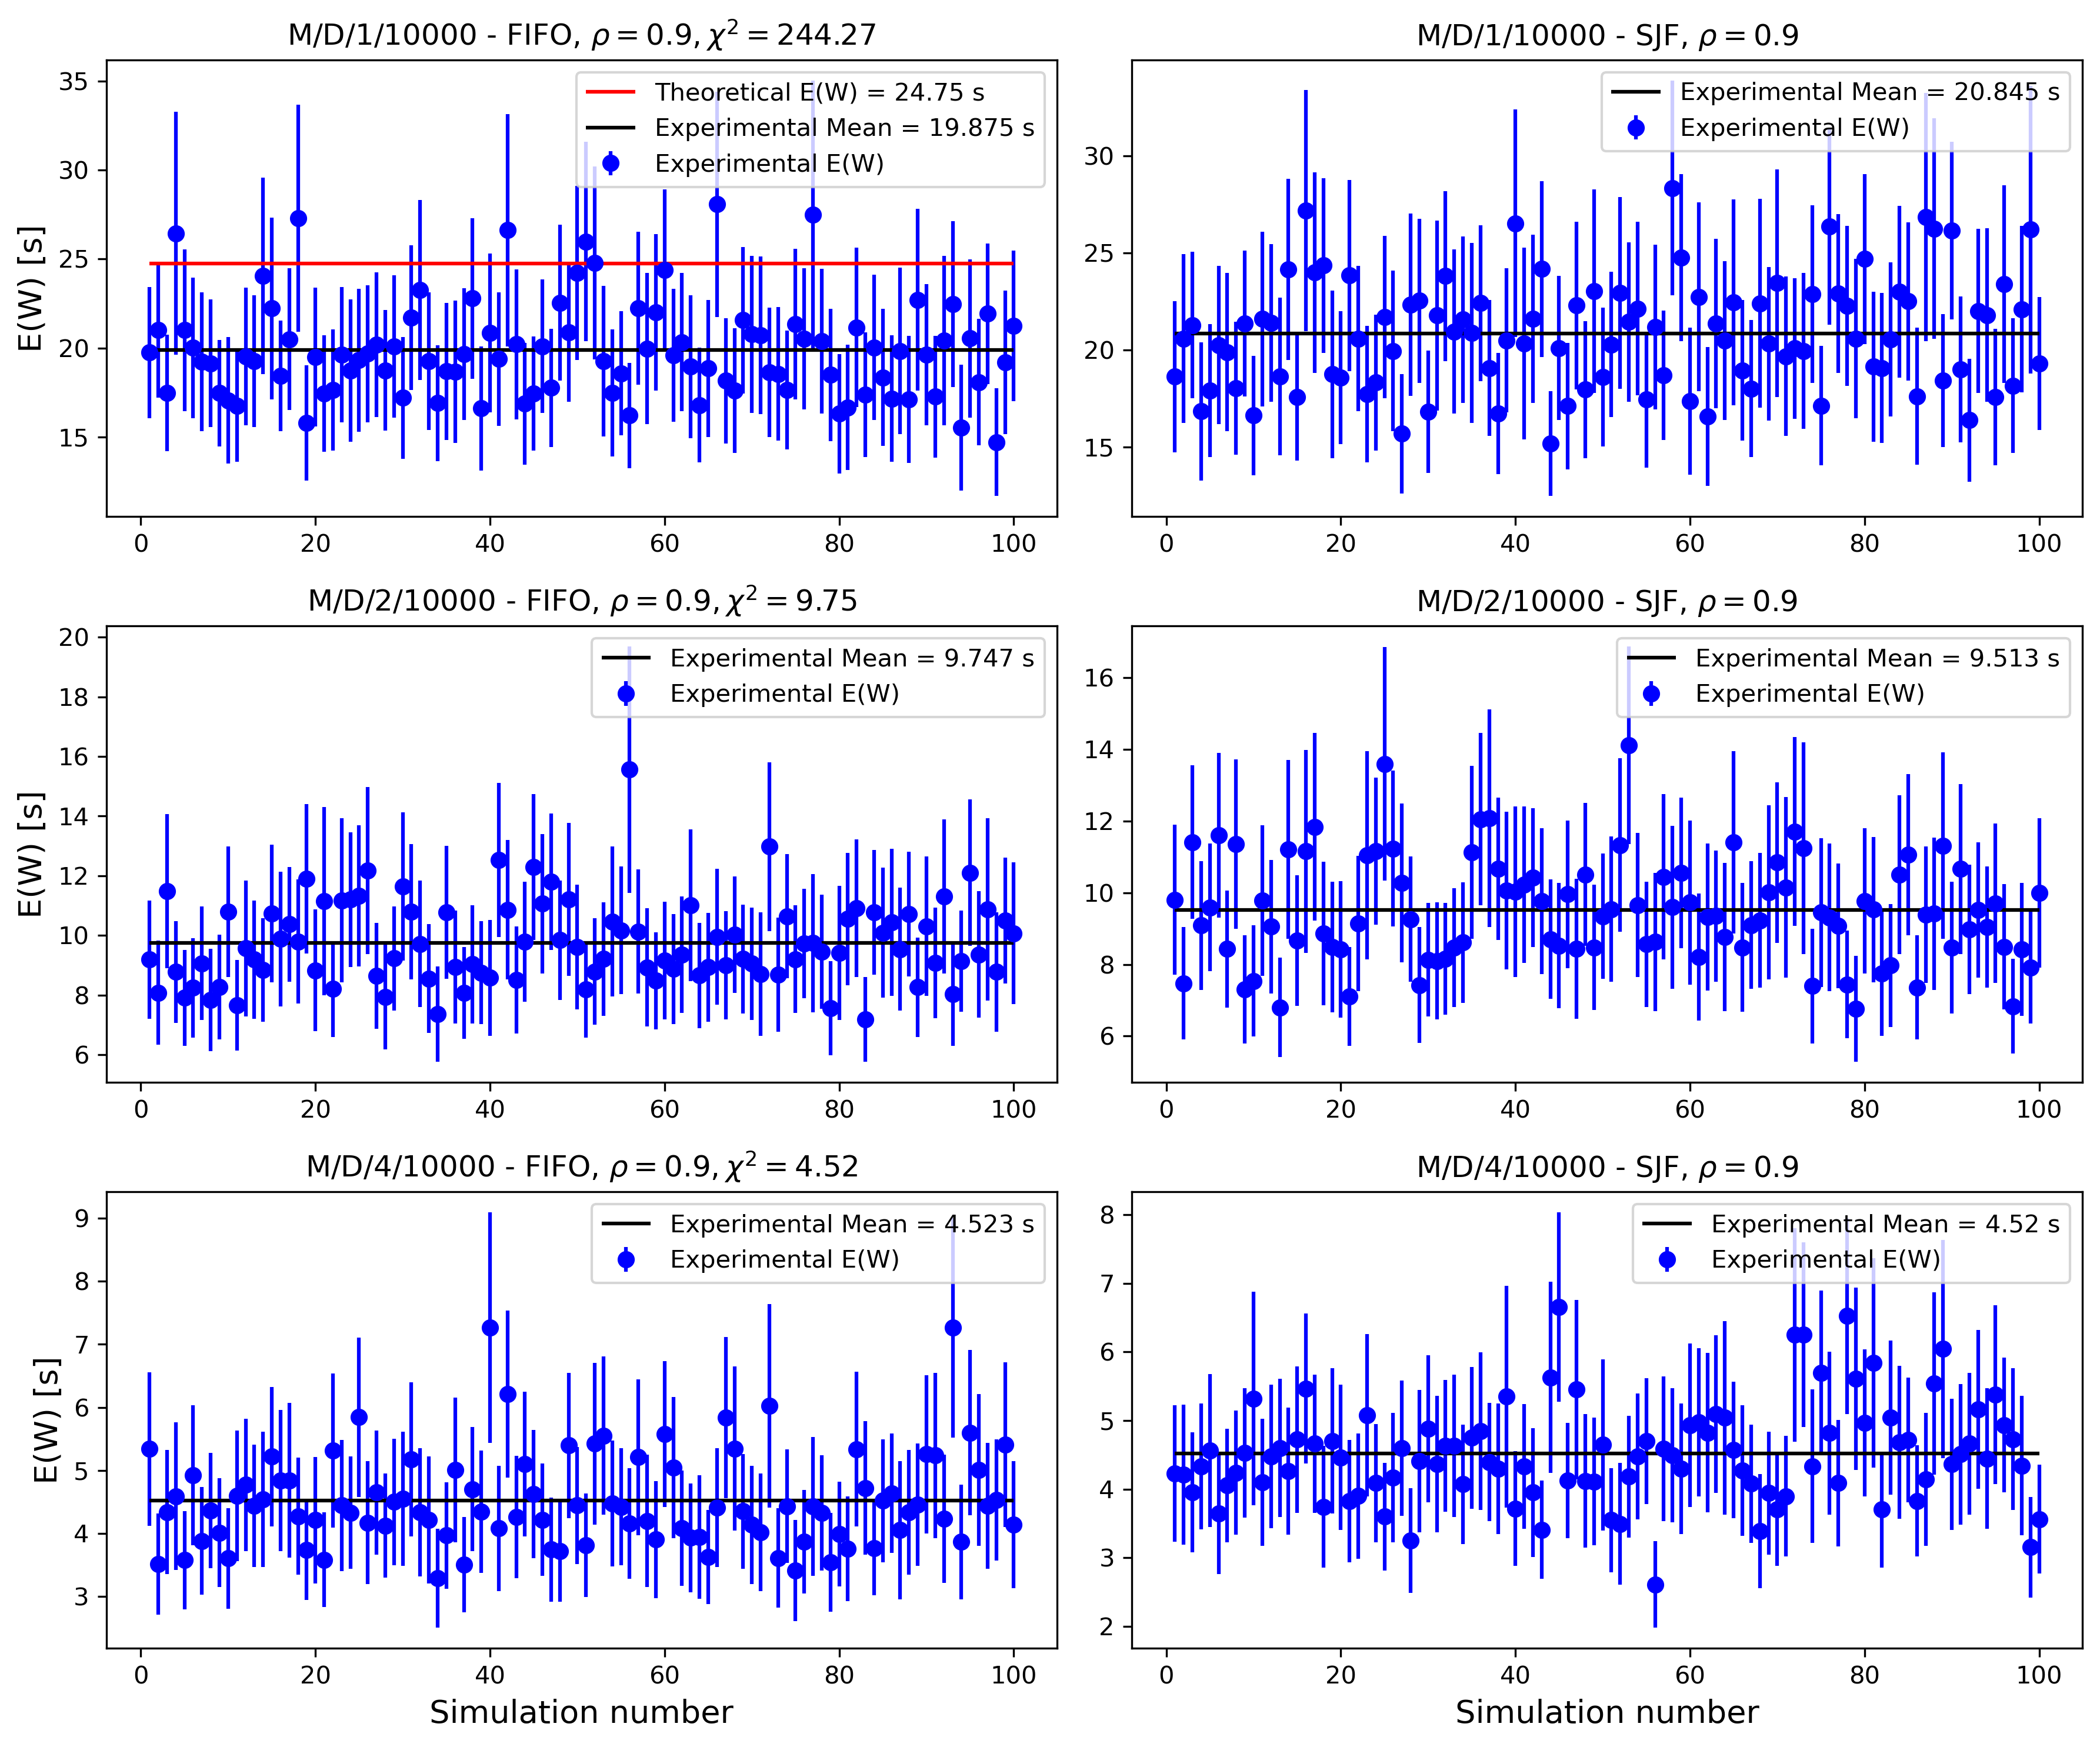

In [27]:
plt.figure(figsize=(12, 10), dpi=300)

plt.subplot(3,2,1)
plt.title(fr'M/D/{num_servers[0]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/(num_servers[0]*(1/D)), 2)}}}, \chi^2 = {round(fifo_single_server_stats_det[3], 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo_det[0], yerr=fifo_single_server_stats_det[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_single_server_stats_det[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_single_server_stats_det[0], 3)} s')
plt.hlines(fifo_single_server_stats_det[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_single_server_stats_det[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,3)
plt.title(fr'M/D/{num_servers[1]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*(1/D)), 2)}}}, \chi^2 = {round(fifo_two_server_mean_det, 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo_det[1], yerr=fifo_two_server_std_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_two_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_two_server_mean_det, 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,5)
plt.title(fr'M/D/{num_servers[2]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[2]*arrival_rate/(num_servers[2]*(1/D)), 2)}}}, \chi^2 = {round(fifo_four_server_mean_det, 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo_det[2], yerr=fifo_four_server_std_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_four_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_four_server_mean_det, 3)} s')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,2)
plt.title(fr'M/D/{num_servers[0]}/{num_requests} - SJF, $\rho = {{{round(arrival_rate/(num_servers[0]*(1/D)), 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_sjf_det[0], yerr=sjf_single_conf95_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_single_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_single_server_mean_det, 3)} s')
plt.legend()

plt.subplot(3,2,4)
plt.title(fr'M/D/{num_servers[1]}/{num_requests} - SJF, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*(1/D)), 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_sjf_det[1], yerr=sjf_two_conf95_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_two_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_two_server_mean_det, 3)} s')
plt.legend()

plt.subplot(3,2,6)
plt.title(fr'M/D/{num_servers[2]}/{num_requests} - SJF, $\rho = {{{round(num_servers[2]*arrival_rate/(num_servers[2]*(1/D)), 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_sjf_det[2], yerr=sjf_four_conf95_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_four_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_four_server_mean_det, 3)} s')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)

plt.tight_layout()
plt.show()

# TODO: Add hyperexponential service distribution

before every simulation of the different queue systems, the seed is reset to ensure that M/M/1 distribution is the same as M/M/n etc.

In [41]:
np.random.seed(2)
num_servers = [1, 2]
num_simulations = 100
num_requests = 10000

In [42]:
sim_means_fifo = np.zeros((len(num_servers), num_simulations))
sim_stds_fifo = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    service_probabilities = [1]  # Example probabilities for different service times
    service_scales = [1/4.5]  # Example service rates
    fifo_result = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, D, scheduler_type="FIFO", queue_type="MMN")

    for i in range(num_simulations):
        sim_means_fifo[j, i] = np.mean(fifo_result[i]["wait_times"][burn_in_count:])
        sim_stds_fifo[j ,i] = np.std(fifo_result[i]["wait_times"][burn_in_count:])

In [43]:
fifo_single_server_stats = calc_statistics(sim_means_fifo[0], sim_stds_fifo[0], num_servers[0]*arrival_rate, service_scales[0], 1, num_simulations, "MMN")
fifo_two_server_stats = calc_statistics(sim_means_fifo[1], sim_stds_fifo[1], num_servers[1]*arrival_rate, service_scales[0], 2, num_simulations, "MMN")

# fifo_four_server_stats = calc_statistics(sim_means_fifo[2], sim_stds_fifo[2], num_servers[1]*arrival_rate, service_scales[0], 2, num_simulations, "MMN")

In [44]:
sim_means_fifo_he = np.zeros((len(num_servers), num_simulations))
sim_stds_fifo_he = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    service_probabilities = [0.75, 0.25]  # Example probabilities for different service times
    service_scales = [1, 1/5]  # Example service rates
    fifo_result_he = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, D, scheduler_type="FIFO", queue_type="MMN")

    for i in range(num_simulations):
        sim_means_fifo_he[j, i] = np.mean(fifo_result_he[i]["wait_times"][burn_in_count:])
        sim_stds_fifo_he[j ,i] = np.std(fifo_result_he[i]["wait_times"][burn_in_count:])

In [45]:
fifo_single_server_stats_he = calc_statistics(sim_means_fifo_he[0], sim_stds_fifo_he[0], num_servers[0]*arrival_rate, service_scales[0], 1, num_simulations, "MMN")
fifo_two_server_stats_he = calc_statistics(sim_means_fifo_he[1], sim_stds_fifo_he[1], num_servers[1]*arrival_rate, service_scales[0], 2, num_simulations, "MMN")


In [55]:
fifo_one_server_mean_he = np.mean(sim_means_fifo_he[0])
fifo_one_server_std_he = 1.96*sim_stds_fifo_he[0]/np.sqrt(num_simulations)
fifo_two_server_mean_he = np.mean(sim_means_fifo_he[1])
fifo_two_server_std_he = 1.96*sim_stds_fifo_he[1]/np.sqrt(num_simulations)

In [46]:
sim_means_fifo_det = np.zeros((len(num_servers), num_simulations))
sim_stds_fifo_det = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    np.random.seed(6)
    service_probabilities = [1]  # Example probabilities for different service times
    service_scales = [1/4.5]  # Example service rates
    fifo_det_result = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, 1/D, scheduler_type="FIFO", queue_type="MDN")

    for i in range(num_simulations):
        sim_means_fifo_det[j, i] = np.mean(fifo_det_result[i]["wait_times"][burn_in_count:])
        sim_stds_fifo_det[j ,i] = np.std(fifo_det_result[i]["wait_times"][burn_in_count:])

In [ ]:
fifo_single_server_stats_det = calc_statistics(sim_means_fifo_det[0], sim_stds_fifo_det[0], arrival_rate, 1/D, 1, num_simulations, "MDN")
fifo_two_server_mean_det = np.mean(sim_means_fifo_det[1])
fifo_two_server_std_det = 1.96*sim_stds_fifo_det[1]/np.sqrt(num_simulations)


In [50]:
np.random.seed(5)
service_times_he = np.array([generate_service_time([0.75, 0.25], [1,1/5]) for _ in range(num_requests)])
service_times_exp = np.array([generate_service_time([1], [1/4.5]) for _ in range(num_requests)])
service_times_D = np.array([1/D for _ in range(num_requests)])

Text(0, 0.5, 'count')

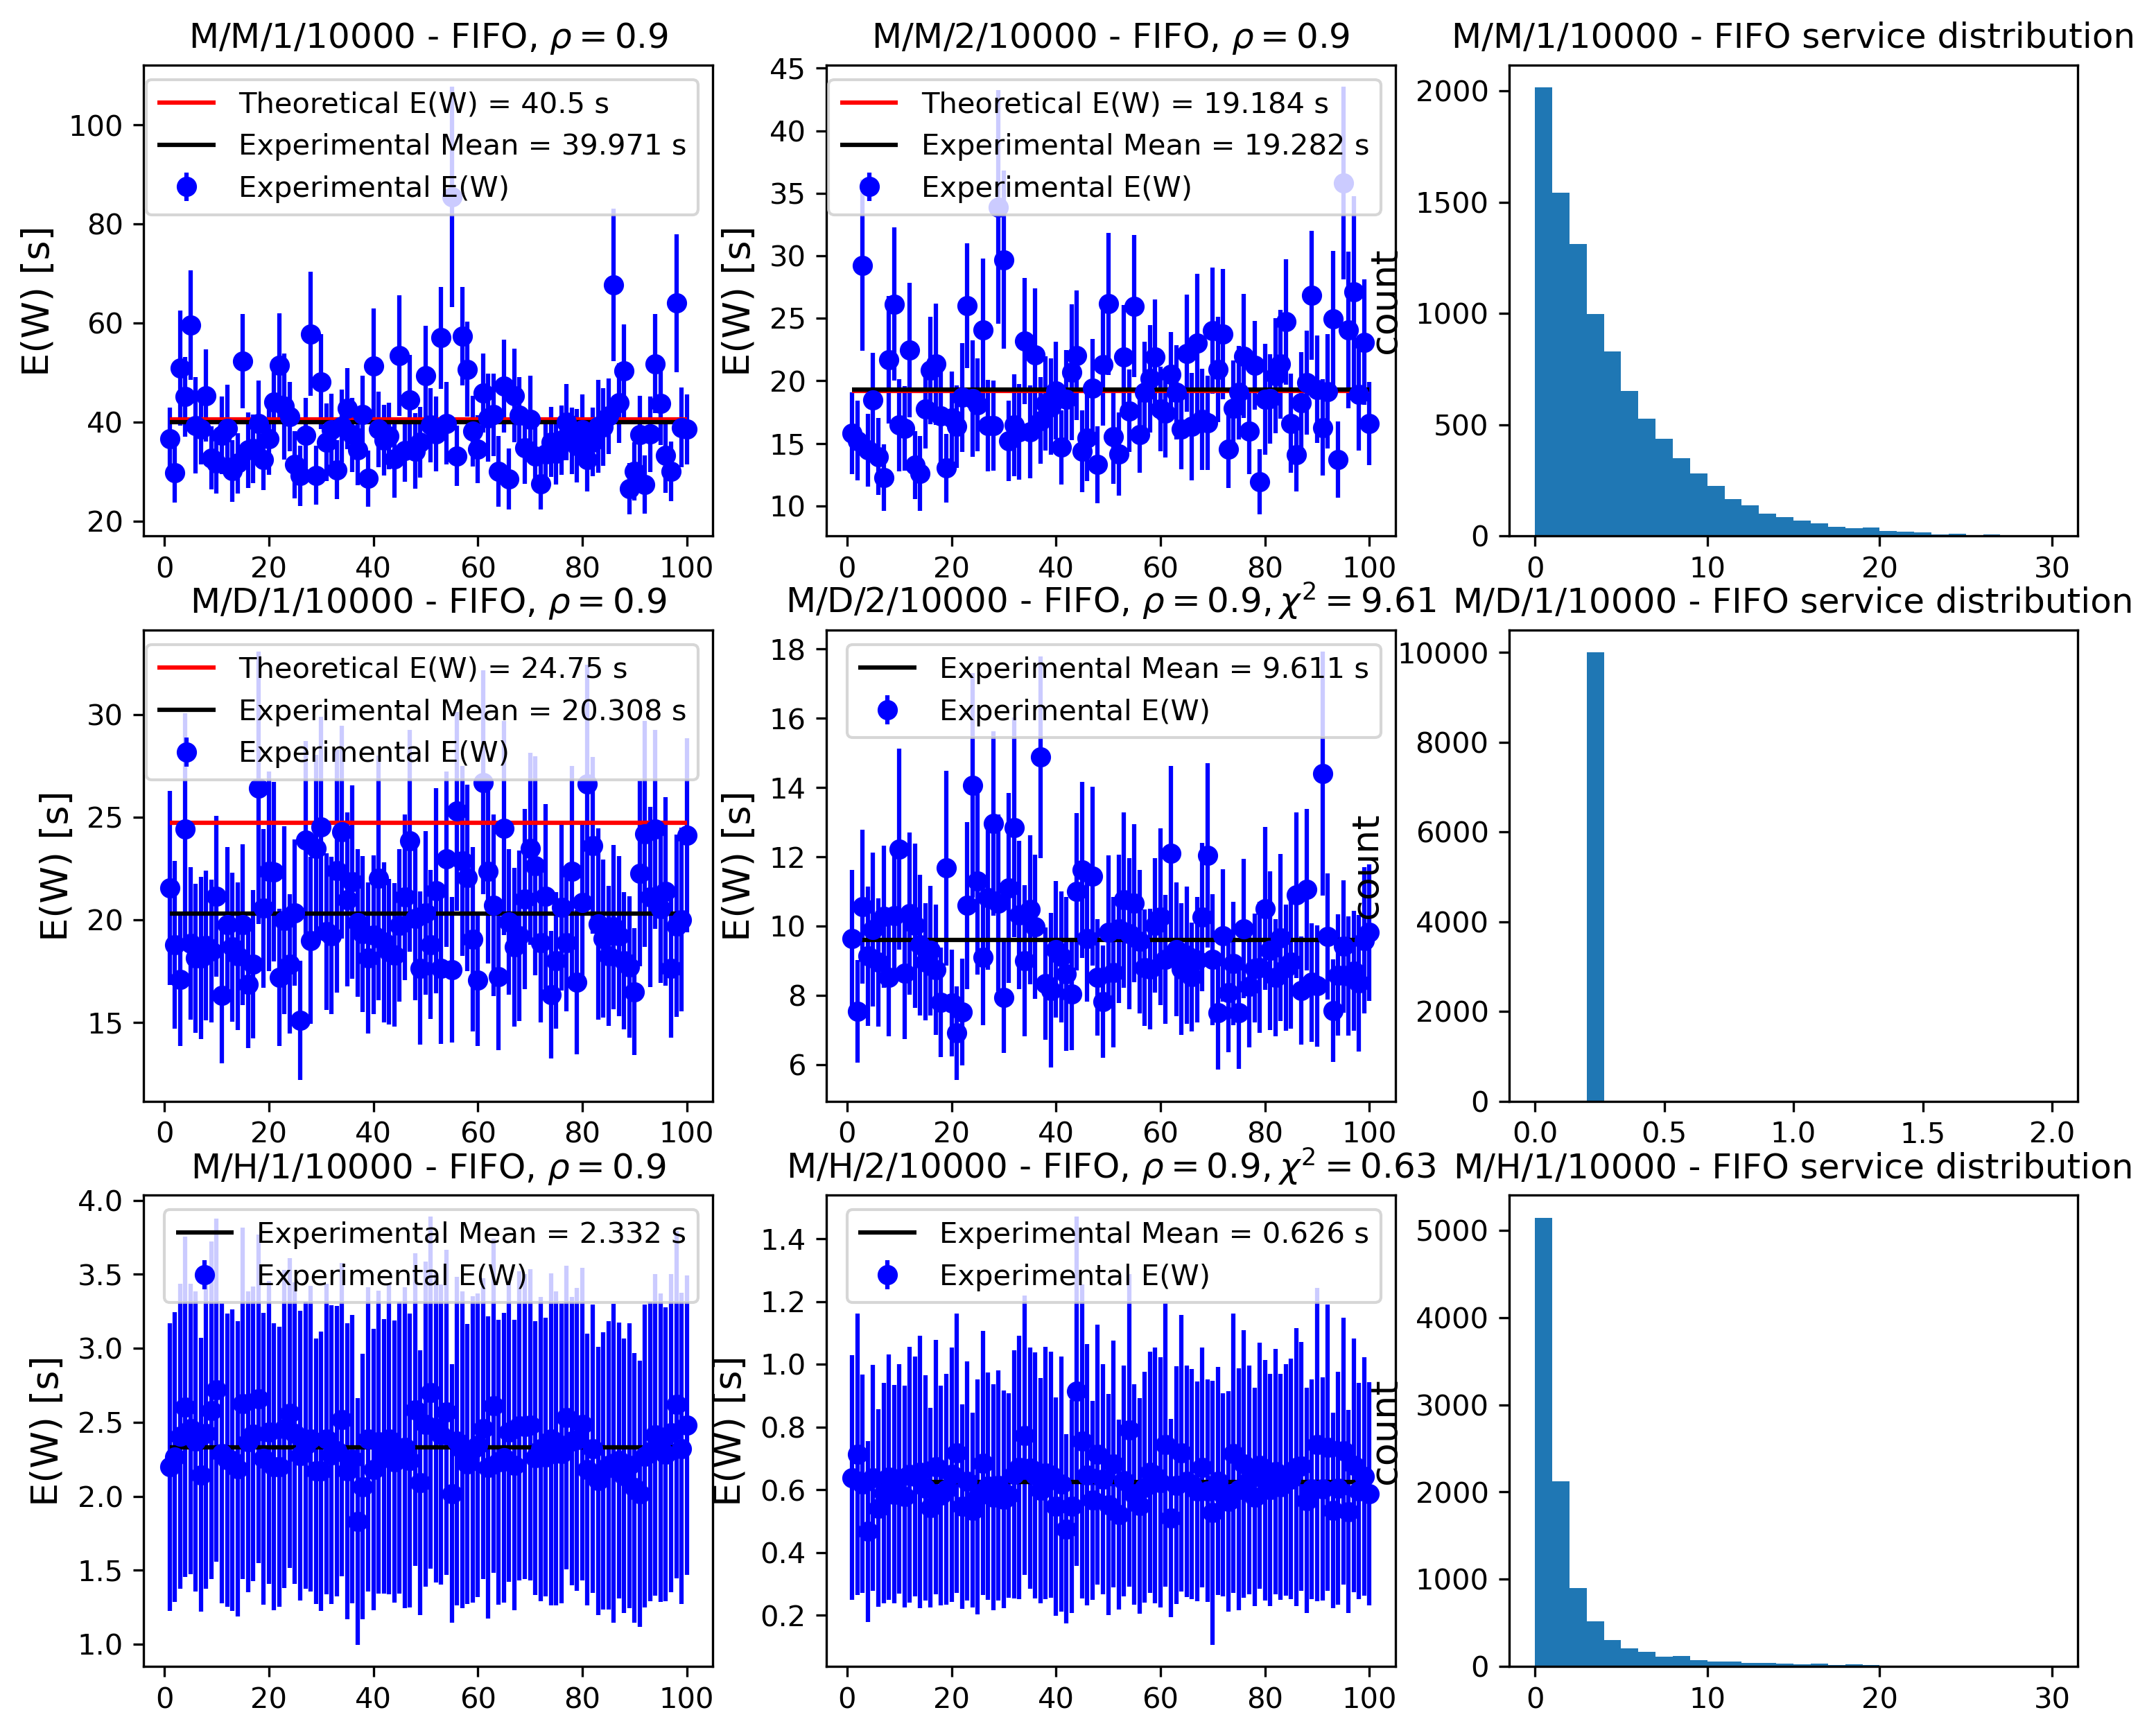

In [57]:
plt.figure(figsize=(12, 10), dpi=300)


plt.subplot(3,3,1)
plt.title(fr'M/M/{num_servers[0]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_fifo[0], yerr=fifo_single_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_single_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_single_server_stats[0], 3)} s')
plt.hlines(fifo_single_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_single_server_stats[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,3,2)
plt.title(fr'M/M/{num_servers[1]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/service_scales[0], 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_fifo[1], yerr=fifo_two_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_two_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_two_server_stats[0], 3)} s')
plt.hlines(fifo_two_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_two_server_stats[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,3,3)
plt.title(fr'M/M/{num_servers[0]}/{num_requests} - FIFO service distribution')
plt.hist(service_times_exp, 30, range=(0,30))
plt.ylabel('count', fontsize=13)


plt.subplot(3,3,4)
plt.title(fr'M/D/{num_servers[0]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/(num_servers[0]*(1/D)), 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_fifo_det[0], yerr=fifo_single_server_stats_det[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_single_server_stats_det[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_single_server_stats_det[0], 3)} s')
plt.hlines(fifo_single_server_stats_det[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_single_server_stats_det[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,3,5)
plt.title(fr'M/D/{num_servers[1]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*(1/D)), 2)}}}, \chi^2 = {round(fifo_two_server_mean_det, 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo_det[1], yerr=fifo_two_server_std_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_two_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_two_server_mean_det, 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,3,6)
plt.title(fr'M/D/{num_servers[0]}/{num_requests} - FIFO service distribution')
plt.hist(service_times_D, 30, range=(0,2))
plt.ylabel('count', fontsize=13)

plt.subplot(3,3,7)
plt.title(fr'M/H/{num_servers[0]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/(num_servers[0]*(1/D)), 2)}}}$')
plt.errorbar(x_axis_plots, sim_means_fifo_he[0], yerr=fifo_single_server_stats_he[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_single_server_stats_he[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_single_server_stats_he[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,3,8)
plt.title(fr'M/H/{num_servers[1]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*(1/D)), 2)}}}, \chi^2 = {round(fifo_two_server_mean_he, 2)}$')
plt.errorbar(x_axis_plots, sim_means_fifo_he[1], yerr=fifo_two_server_std_he, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_two_server_mean_he, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_two_server_mean_he, 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,3,9)
plt.title(fr'M/H/{num_servers[0]}/{num_requests} - FIFO service distribution')
plt.hist(service_times_he, 30, range=(0,30))
plt.ylabel('count', fontsize=13)